## Imports

In [1]:
import os
import h5py as h5
import json
from copy import deepcopy
import multiprocessing

import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
    
# local imports (found in this repo)
from utils import *
from deconv import *
from releaser import Releaser, mini_releaser
from animator import SacSacAnimator, ball_sticks
from scalebars import add_scalebar
from experiments import distribution_run, incremental_sust_removal_run

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "data/"

### Use inverse transform sampling to create probability distributions that mimic the shape of these mearurements

These functions can be used to distribute a given number of bipolar inputs over a sac dendrite. Note that the desired end % coverage of the model SACs will need to be achieved by picking the appropriate number of samples.

### Ding Bipolar Distribution
Values eyeballed from `Species-specific wiring for direction selectivity in the mammalian retina (Ding et al., 2016`. Figure 2e, type 7 (yellow line) used for sustained, and combined type 5s (grey line) used for transient.

<IPython.core.display.Javascript object>


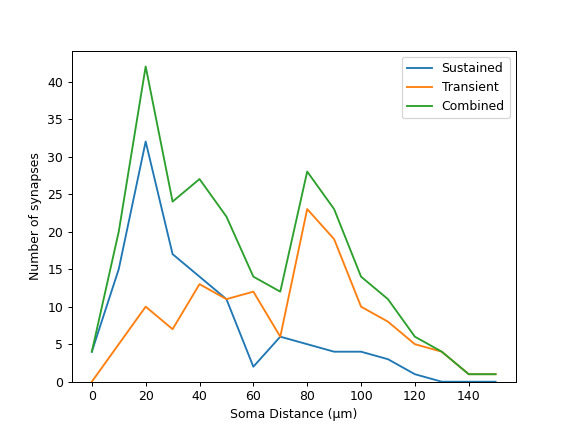

total sustained: 118
total transient: 135


In [4]:
ding_soma_dist = np.arange(0, 160, 10)
ding_sust_coverage = np.array([4, 15, 32, 17, 14, 11, 2, 6, 5, 4, 4, 3, 1, 0, 0, 0])
ding_all5_coverage = np.array([0, 5, 10, 7, 13, 11, 12, 6, 23, 19, 10, 8, 5, 4, 1, 1])
ding_5t_coverage = np.array([0, 5, 2, 2, 5, 5, 7, 6, 8, 8, 6, 5, 4, 4, 1, 0])

ding_trans_coverage = ding_all5_coverage
# ding_trans_coverage = ding_5t_coverage
ding_combo_coverage = ding_sust_coverage + ding_trans_coverage

ding_coverage_fig, ding_coverage_ax = plt.subplots(1)
ding_coverage_ax.plot(ding_soma_dist, ding_sust_coverage, label="Sustained")
ding_coverage_ax.plot(ding_soma_dist, ding_trans_coverage, label="Transient")
ding_coverage_ax.plot(ding_soma_dist, ding_combo_coverage, label="Combined")

ding_coverage_ax.set_ylim(0)
ding_coverage_ax.set_xlabel("Soma Distance (μm)")
ding_coverage_ax.set_ylabel("Number of synapses")
ding_coverage_ax.legend()
ding_coverage_fig.show()

print("total sustained:", np.sum(ding_sust_coverage))
print("total transient:", np.sum(ding_trans_coverage))

<IPython.core.display.Javascript object>


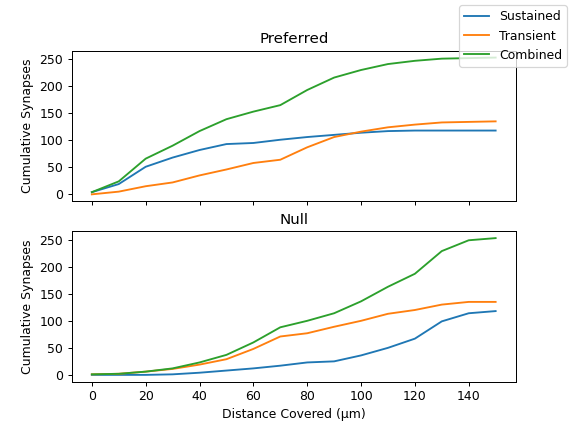

In [5]:
ding_cum_fig, ding_cum_ax = plt.subplots(2, sharex=True, sharey=True)

ding_cum_ax[0].plot(ding_soma_dist, np.cumsum(ding_sust_coverage), label="Sustained")
ding_cum_ax[0].plot(ding_soma_dist, np.cumsum(ding_trans_coverage), label="Transient")
ding_cum_ax[0].plot(ding_soma_dist, np.cumsum(ding_combo_coverage), label="Combined")

ding_cum_ax[1].plot(ding_soma_dist, np.cumsum(np.flip(ding_sust_coverage)))
ding_cum_ax[1].plot(ding_soma_dist, np.cumsum(np.flip(ding_trans_coverage)))
ding_cum_ax[1].plot(ding_soma_dist, np.cumsum(np.flip(ding_combo_coverage)))

ding_cum_ax[0].set_title("Preferred")
ding_cum_ax[1].set_title("Null")
for ax in ding_cum_ax:
    ax.set_ylabel("Cumulative Synapses")
ding_cum_ax[1].set_xlabel("Distance Covered (μm)")
ding_cum_fig.legend()

<IPython.core.display.Javascript object>


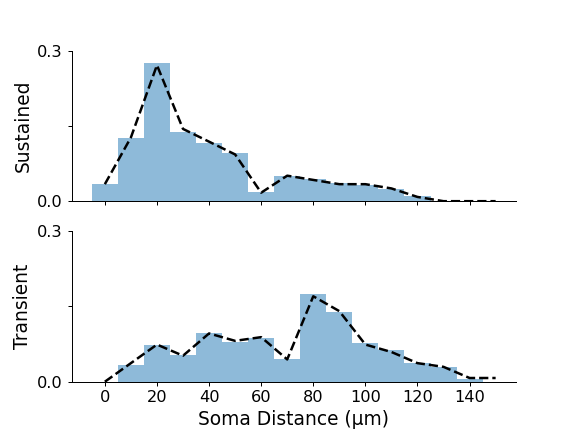

In [6]:
size = 10000
bin_size = ding_soma_dist[1] - ding_soma_dist[0]  # shift over so points are ends of bins
ding_sust_f = inverse_transform(ding_soma_dist + bin_size, ding_sust_coverage)
ding_trans_f = inverse_transform(ding_soma_dist + bin_size, ding_trans_coverage)

ding_bp_hist_fig, ding_bp_hist_ax = plt.subplots(2, sharex=True, sharey=True)

ding_bp_hist_ax[0].hist(
    ding_sust_f(np.random.uniform(size=size)), bins=ding_soma_dist, 
    align="left", hatch="", alpha=0.5,
)
ding_bp_hist_ax[0].plot(
    ding_soma_dist, ding_sust_coverage / np.sum(ding_sust_coverage) * size,
    c="black", linestyle="--", linewidth=2
)

ding_bp_hist_ax[1].hist(
    ding_trans_f(np.random.uniform(size=size)), bins=ding_soma_dist, 
    align="left", hatch="", alpha=0.5,
)
ding_bp_hist_ax[1].plot(
    ding_soma_dist, ding_trans_coverage / np.sum(ding_trans_coverage) * size,
    c="black", linestyle="--", linewidth=2
)

ding_bp_hist_ax[0].set_yticks([size * rel for rel in [0, 0.15, 0.3]])
ding_bp_hist_ax[0].set_yticklabels(["0.0", "", "0.3"])
ding_bp_hist_ax[0].set_ylabel("Sustained", fontsize=15)
ding_bp_hist_ax[1].set_ylabel("Transient", fontsize=15)
ding_bp_hist_ax[1].set_xlabel("Soma Distance (μm)", fontsize=15)

clean_axes(ding_bp_hist_ax)
for ax in ding_bp_hist_ax:
    ax.tick_params(axis='both', which='major', labelsize=13)
    
ding_bp_hist_fig.show()
ding_bp_hist_fig.savefig(os.path.join(base_path, "bp_dist_hist.svg"), bbox_inches="tight")

### Release Rates

In [7]:
quanta_h5 = base_path + "static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

<IPython.core.display.Javascript object>


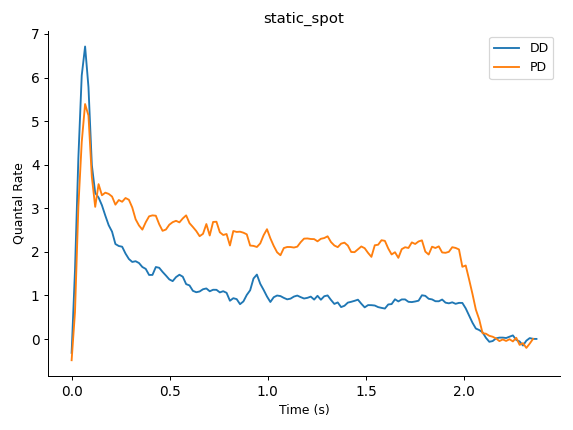

In [8]:
vel = 500
rate_dt = quantum_pack["rec_dt"]

rate_fig, rate_ax = plt.subplots(len(release_rates["DD"][vel]), sharex=True, sharey=True)
rate_ax = [rate_ax] if len(release_rates["DD"][vel]) == 1 else rate_ax
for depth, stims in release_rates.items():
    for ax, (stim, rate) in zip(rate_ax, stims[vel].items()):
        ax.plot(np.arange(len(rate)) * rate_dt, rate, label=depth)

for ax, stim in zip(rate_ax, release_rates["DD"][vel].keys()):
    ax.legend()
    ax.set_title(stim)
    ax.set_ylabel("Quantal Rate")
    clean_axes(ax)

rate_ax[-1].set_xlabel("Time (s)")
rate_fig.tight_layout()
rate_fig.show()

In [9]:
interp_dt = 1 / 1000  # for model
def make_releaser(rec):
    return Releaser(
        lambda v: train_maker(
            velocity_rate(
                rec,
                rate_dt,
                quantum_pack["quantum"],
                v,
                bsln_start=100,
                bsln_end=150,
                step=1,
                offset=0.,
                model_dt=interp_dt,
            ),
            interp_dt,
        )
    )
    
bp_releasers = {
   "sust": make_releaser(bp_inputs["sust"]), 
   "trans": make_releaser(bp_inputs["trans"]), 
}
print("release rate recording freq: %.2f" % (1 / rate_dt))
print("target simulation freq: %.2f" % (1 / interp_dt))
print("rate conversion factor: %.2f" % (rate_dt / interp_dt))

release rate recording freq: 58.25
target simulation freq: 1000.00
rate conversion factor: 17.17


In [10]:
bps = {
    "bp_props": {
        "sust": {"tau1": 0.14, "tau2": 0.54, "rev": 0, "weight": .00017215, "delay": 0},
        "trans": { "tau1": 0.14, "tau2":  0.54, "rev": 0, "weight": .00017215, "delay": 0},    
    },
    "bp_locs": {
        "sust": ding_sust_f(np.random.uniform(size=6)).tolist(), # 6 
        "trans": ding_trans_f(np.random.uniform(size=12)).tolist(),  # 12
    },
}

def bp_scaling(loc_scaling=False):
    frac = 0.6
    end = 150
    return {
        "loc_scaling": loc_scaling, 
        "bp_loc_scaling": {
            "sust":
                {
                    "weight": (
                        lambda loc, w: (1 - frac) * w + w * frac * max(0, end - loc) / end),
                    "tau1": (lambda loc_scaling, t1: t1),
                    "tau2": (lambda loc_scaling, t2: t2),
                },
            "trans":
                {
                    "weight": (
                        lambda loc, w: (1 - frac) * w + w * frac * max(0, end - loc) / end),
                    "tau1": (lambda loc_scaling, t1: t1),
                    "tau2": (lambda loc_scaling, t2: t2),
                },
        },
    }

membrane = {
    "soma_gleak_hh": 1 / 21700,
    "dend_gleak_hh": 1 / 21700,
    "soma_ra": 150,
    "dend_ra": 150,
}

soma_kv3 = 0.12
soma_kdr = 0.003 #0.003
conductances = {
    "term_cat": 0.0,
    "dend_cal": 0.001,
    "term_cal": 0.001,
    "term_na": 0.0, 
    "dend_nav1_8": 0.00, 
    "term_nav1_8": 0.003,
    "soma_k": soma_kdr,
    "initial_k": soma_kdr * 0.92,
    "dend_k": soma_kdr * 0.64,
    "term_k": soma_kdr * 0.59,
}

params = {
    **membrane,
    **bps,
    **bp_scaling(loc_scaling=True),
    "bp_releasers": bp_releasers,
    **conductances,
}

### Load existing data, or run NEURON model to generate new data
Parameters can be provided to the `SacPair` class in the form of a dict which will be used to overwrite the default properties of the `Sac` objects generated (see `sac_pair.py`).

### Various example `.h5`s:

In [11]:
model_path = base_path + "model_runs/"
save_name = "test_run"
load_name = None

mode = "distribution"

if load_name is not None:
    with h5.File(os.path.join(model_path, load_name + ".h5"), "r") as f:
        data = unpack_hdf(f)
else:
    import sac_pair
    sac_params = params
    
    if mode == "distribution":
        save_path = os.path.join(model_path, save_name) + ".h5"
        distribution_run(
            save_path,
            sac_params,
            ding_sust_f, ding_trans_f,
#             ding_trans_f, ding_sust_f,
            n_sust=6,
            n_trans=12,
            dist_trials=1,
            mech_trials=1,
            batch=8,
            conds={"control"},
            velocities=[0.05, .1, 0.15, 0.2, .25, .5, .75, 1, 1.25, 1.5],
        )
        with h5.File(save_path, "r") as pckg:
            if len(pckg.keys()) < 40 or False:
                data = unpack_hdf(pckg)
    elif mode == "sust_trans_range":
        incremental_sust_removal_run(
            os.path.join(model_path, save_name) + ".h5",
            sac_params,
            mech_trials=20,
            batch=4,
            velocities=[0.05, .1, 0.15],
        )
    else:
        raise Exception("No valid mode provided.")

if mode == "distribution":
    first_cond = list(data[0].keys())[0]
    print("params condition: %s" % first_cond)
    model_params = {i: json.loads(d[first_cond]["model_params"]) for i, d in data.items()}
    exp_params = {i: json.loads(d[first_cond]["exp_params"]) for i, d in data.items()}
    exps = {i: {k: v["data"] for k, v in d.items()} for i, d in data.items()}
    
    for i in exps.keys():
        for cond in exps[i].keys():
            exps[i][cond]["combined_bps"] = {
                n: {
                    m: np.sum(
                        [bp[m] for bps in sac.values() for bp in bps.values()], axis=0
                    )
                    for m in ["g", "i"]
                }
                for n, sac in exps[i][cond]["bps"].items()
            }
    
    avg_exps = {i: apply_to_data(lambda a: np.mean(a, axis=0), e) for i, e in exps.items()}
else:
    print("Completed Sustained BP removal run.")
    print("The data is unsuitable for this notebook, analyze elsewhere.")

distribution trials 1 to 1 (of 1)...
Done!
params condition: control


### Common axes, labels, and parameters generated or pulled from the control experiment data which apply to all conditions

In [12]:
dt = exp_params[0]["dt"]
rec_xaxis = np.arange(0, exp_params[0]["tstop"] + dt, dt)
velocities = exp_params[0]["velocities"]

### Experiment dict contents / shapes

In [14]:
print("Electrode recording dict keys:", [k for k in exps[0][first_cond]["soma"]["a"].keys()])
print("Recording shape:", exps[0][first_cond]["soma"]["a"]["v"].shape)

Electrode recording dict keys: ['cai', 'ica', 'v']
Recording shape: (1, 10, 6001)


<IPython.core.display.Javascript object>


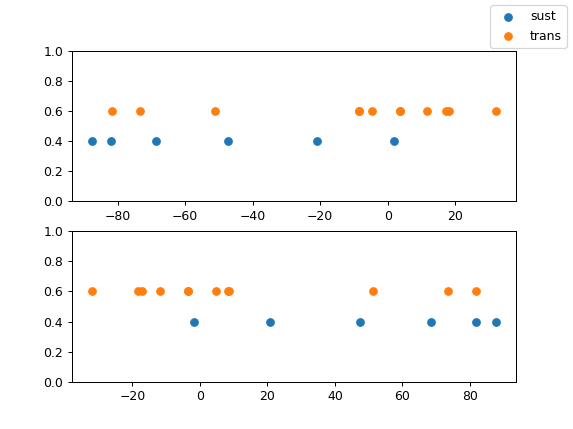

In [15]:
exp_idx = 0
ff, aa = plt.subplots(2)
a_locs = model_params[exp_idx]["a"]["bp_xy_locs"]
b_locs = model_params[exp_idx]["b"]["bp_xy_locs"]
aa[0].scatter(a_locs["sust"]["x"], np.array(a_locs["sust"]["y"]) + 0.4, label="sust")
aa[0].scatter(a_locs["trans"]["x"], np.array(a_locs["trans"]["y"]) + 0.6, label="trans")
aa[1].scatter(b_locs["sust"]["x"], np.array(b_locs["sust"]["y"]) + 0.4)
aa[1].scatter(b_locs["trans"]["x"], np.array(b_locs["trans"]["y"]) + 0.6) 
for a in aa:
    a.set_ylim (0, 1)
ff.legend()

### Model Schematic and Animation
Colours are normalized to the maximum values of their corresponding measures across all velocities and both SACs in a particular condition. Thus, for the matching visible components (e.g. 2nd trans BPCs or terminals), the colour scaling is shared.

- **soma:** membrane voltage at centre
- **terminal:** membrane voltage at tip (GABA pre-synapse)
- **bipolars:** conductance

In [16]:
exp_idx = 0
sac_anim = SacSacAnimator(
    exps[exp_idx],
    exp_params[exp_idx],
    model_params[exp_idx], 
    reveal_time=False
)
sac_anim_fig, sac_anim_ax = sac_anim.build_interactive_fig(figsize=(8, 15))

KeyError: 'gaba'

### PN DSi measurements
Here the bar is simply moving in the same direction, over SAC A then SAC B, but we can use the signals in the opposing SACs to calculate a preferred minus null direction selective index.

- **peak:** Using the deflection from the minimum voltage
- **thresh_area:** Area under the voltage above a specified threshold
- **iCa**: Area of calcium current (polarity flipped to positive)
- **gaba:** Area of GABA conductance *applied* the *opposing* SAC  

In [22]:
thresh = -40
dsis = {
    i: { 
        cond: {
            "peak": pn_dsi(
                peak_vm_deflection(exp["term"]["a"]["v"]),
                peak_vm_deflection(exp["term"]["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(exp["term"]["a"]["v"], thresh),
                thresholded_area(exp["term"]["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(exp["term"]["a"]["ica"] * -1, axis=-1),
                np.sum(exp["term"]["b"]["ica"] * -1, axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(exp["term"]["a"]["cai"], axis=-1),
                np.max(exp["term"]["b"]["cai"], axis=-1)
            ),
        }
        for cond, exp in es.items()
    } 
    for i, es in exps.items()
}

avg_dsis = {
    cond: {
        metric: np.mean([dsis[i][cond][metric] for i in dsis.keys()], axis=0)
        for metric in dsis[0][cond].keys()
    }
    for cond in dsis[0].keys()
}

<IPython.core.display.Javascript object>


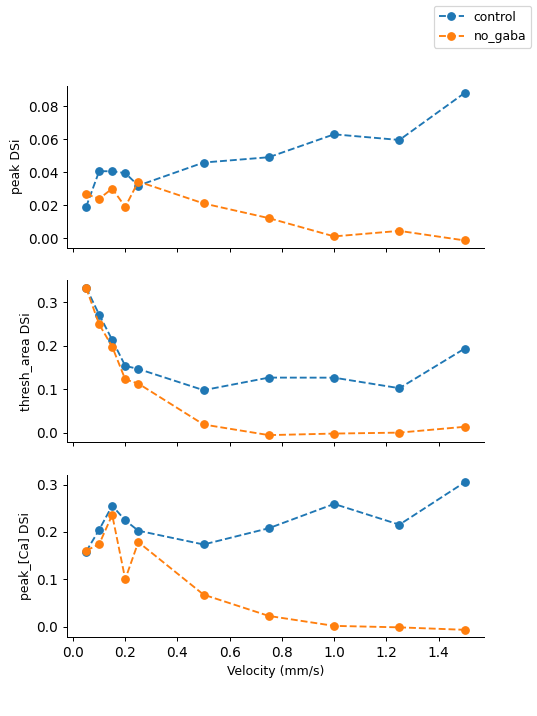

In [23]:
show_metrics = ["peak", "thresh_area", "peak_[Ca]"]
dsi_fig, dsi_ax = plt.subplots(len(show_metrics), sharex=True, figsize=(6, 8))
for (cond, ds) in avg_dsis.items():
    for i, (a, m) in enumerate(zip(dsi_ax, show_metrics)):
        lbl = {"label": cond} if not i else {}  # only add label once for each condition
        a.plot(velocities, np.mean(ds[m], axis=0), linestyle="--", marker="o", **lbl)

for a, metric in zip(dsi_ax, show_metrics):
    a.set_ylabel("%s DSi" % metric)
    clean_axes(a)

dsi_ax[-1].set_xlabel("Velocity (mm/s)")
dsi_fig.legend()
dsi_fig.show()

### Terminal membrane voltage and (proximal) GABA conductance
Trial averages of membrane voltage (recorded at the distal tip) for each membrane, along with the GABA conductance they recieved proximal to their soma from the opposing SAC. Legend indicates the velocity (in mm/s) corresponding to each mean recording presented.

A figure is generated for each of the experimental conditions.

In [ ]:
exp_idx = 0
alpha = .8
rec_figs = {}

for cond, ex in exps[exp_idx].items():
    fig, ax = plt.subplots(2, 2, sharex="col", sharey="row",figsize=(8, 8))
    rec_figs[cond] = {"fig": fig, "ax": ax}
    
    for vel, v_a, v_b, ica_a, ica_b in zip(
        velocities,
        np.mean(ex["term"]["a"]["v"], axis=0), 
        np.mean(ex["term"]["b"]["v"], axis=0),
        np.mean(ex["term"]["a"]["ica"], axis=0), 
        np.mean(ex["term"]["b"]["ica"], axis=0),
    ):
        ax[0][0].plot(rec_xaxis, v_a, alpha=alpha)
        ax[0][1].plot(rec_xaxis, v_b, alpha=alpha)
        ax[1][0].plot(rec_xaxis, ica_a, alpha=alpha)
        ax[1][1].plot(rec_xaxis, ica_b, alpha=alpha)

    fig.suptitle(cond)
    ax[0][0].set_title("Sac A")
    ax[0][1].set_title("Sac B")
    ax[0][0].set_ylabel("Terminal Voltage (mV)")
    ax[1][0].set_ylabel("Terminal iCa (mA/cm2)")
    ax[1][0].set_xlabel("Time (ms)")
    ax[1][1].set_xlabel("Time (ms)")
    fig.legend()
    fig.show()

### Terminal voltages at select velocities and conditions

In [ ]:
exp_idx = 0
display_conds = ["control", "all_trans"]
# display_vel_idxs = [2, 6, -1]
display_vel_idxs = [0, 2, -1]

vm_fig, vm_ax = plt.subplots(
    len(display_vel_idxs),
    2,
    sharex="col",
    sharey="row",
    figsize=(12, 8)
)

for cond in display_conds:
    for i, row in zip(display_vel_idxs, vm_ax):
        row[0].set_ylabel("Terminal (mV) [ %s mm/s ]" % velocities[i], fontsize=12)
        row[0].set_ylim(-70, -40)
        for ax, (n, sac) in zip(row, exps[exp_idx][cond]["term"].items()):
            ax.plot(rec_xaxis, np.mean(sac["v"][:, i], axis=0), label=cond, alpha=.8)
            clean_axes(ax)

for ax in vm_ax[-1]:
    ax.set_xlim(0, 1000)
    
        
vm_ax[0][0].set_title("Sac A", fontsize=14)
vm_ax[0][1].set_title("Sac B", fontsize=14)
vm_ax[-1][0].set_xlabel("Time (ms)", fontsize=12)
vm_ax[-1][1].set_xlabel("Time (ms)", fontsize=12)
vm_ax[0][0].legend(fontsize=12)
vm_fig.tight_layout()
vm_fig.show()

### Testing terminal calcium accumulation mechanism (display for select conditions at chosen velocities)

In [ ]:
exp_idx = 0
display_conds = ["control", "all_trans"]
display_vel_idxs = [0, 2, -1]

vm_fig, vm_ax = plt.subplots(
    len(display_vel_idxs),
    2,
    sharex="col",
    sharey="row",
    figsize=(8, 8)
)

for cond in display_conds:
    for i, row in zip(display_vel_idxs, vm_ax):
        row[0].set_ylabel("Terminal Ca conc [ %s mm/s ]" % velocities[i], fontsize=12)
        for ax, (n, sac) in zip(row, exps[exp_idx][cond]["term"].items()):
            ax.plot(rec_xaxis, np.mean(sac["cai"][:, i], axis=0), label=cond, alpha=.8)
            clean_axes(ax)

for ax in vm_ax[-1]:
    ax.set_xlim(0, 1000)
    
        
vm_ax[0][0].set_title("Sac A", fontsize=14)
vm_ax[0][1].set_title("Sac B", fontsize=14)
vm_ax[-1][0].set_xlabel("Time (ms)", fontsize=12)
vm_ax[-1][1].set_xlabel("Time (ms)", fontsize=12)
vm_ax[0][0].legend(fontsize=12)
vm_fig.tight_layout()
vm_fig.show()

### Second animator instance for creating gifs (if desired)

In [ ]:
exp_idx = 0
gif_anim = False
if gif_anim:
    sac_gif_anim = SacSacAnimator(
        exps[exp_idx],
        exp_params[exp_idx], 
        model_params[exp_idx],
        reveal_time=True
    )
    sac_gif_anim_fig, sac_gif_anim_ax1= sac_gif_anim.build_animation_fig(figsize=(8, 12), frameon=False)

In [ ]:
if gif_anim:
    params = [
#         {"vel_idx": 0, "n_frames": 150, "dt": 20, "gif_step": 60},
#         {"vel_idx": 1, "n_frames": 150, "dt": 10, "gif_step": 60},
#         {"vel_idx": 5, "n_frames": 100, "dt": 5, "gif_step": 60},
#         {"vel_idx": 8, "n_frames": 150, "dt": 2, "gif_step": 60},
    ]

    for ps in params:
        sac_gif_anim.create_vel_gifs(
            os.path.join(base_path, "gifs"),
            ps["n_frames"],
            vel_idx=ps["vel_idx"],
            dt=ps["dt"],
            dpi=100,
            gif_step=ps["gif_step"],
        )

In [ ]:
# cond = "control"
cond = "no_gaba"
if "vc" in exps[0][cond]:
    avg_vc_i = np.mean(exps[0][cond]["vc"]["a"], axis=0)
    
    vel_idxs = [0, -1]
    all_soma_vci_avg_fig, all_soma_vci_avg_ax = plt.subplots(1)
    for i in vel_idxs:
        all_soma_vci_avg_ax.plot(rec_xaxis, avg_vc_i[i], alpha=0.5)
        
    all_soma_vci_avg_ax.set_xlim(0)
    all_soma_vci_avg_ax.set_ylabel("clamp current (nA)")
    all_soma_vci_avg_ax.set_xlabel("Time (ms)")
    all_soma_vci_avg_fig.show()

In [ ]:
exp_idx = 2
vel_idx = 1
display_conds = ["control", "all_trans"]
cond_to_title = {"control": "Control", "all_trans": "All Transient"}

ex_fig, ex_ax = plt.subplots(
    4,
    2,
    sharex="col",
    sharey="row",
    figsize=(8, 8)
)

for i, cond in enumerate(display_conds):
    if not i:
        ex_ax[0][i].set_ylabel("Bipolar Conductance", fontsize=12)
        ex_ax[3][i].set_ylabel("Terminal [Ca++]", fontsize=12)
        ex_ax[2][i].set_ylabel("Terminal Vm (mV)", fontsize=12)
        ex_ax[1][i].set_ylabel("Somatic Vm (mV)", fontsize=12)
    
    for n in exps[exp_idx][cond]["term"].keys():
        lbl = "sac %s" % n
        ex_ax[0][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["combined_bps"][n]["g"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
        ex_ax[1][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["soma"][n]["v"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        ) 
        ex_ax[2][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["term"][n]["v"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
        ex_ax[3][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["term"][n]["cai"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
    ex_ax[0][i].set_title(cond_to_title[cond])
    ex_ax[-1][i].set_xlabel("Time (ms)", fontsize=12)

for row in ex_ax:
    for col in row:
        clean_axes(col)
        
for ax in ex_ax[-1]:
    ax.set_xlim(50)
    
ex_ax[0][0].legend(fontsize=12)
ex_fig.tight_layout()
ex_fig.show()

<IPython.core.display.Javascript object>


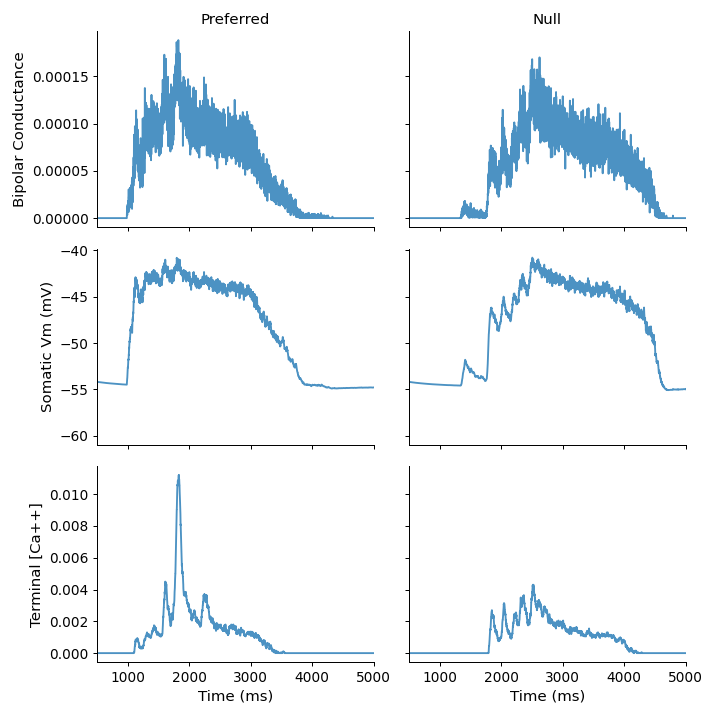

In [22]:
exp_idx = 2
vel_idx = 1
cond = "control"

pref_null_fig, pref_null_ax = plt.subplots(
    3,
    2,
    sharex="col",
    sharey="row",
    figsize=(8, 8)
)
for i, (sac, title) in enumerate([("a", "Preferred"), ("b", "Null")]):
    if not i:
        pref_null_ax[0][i].set_ylabel("Bipolar Conductance", fontsize=12)
        pref_null_ax[1][i].set_ylabel("Somatic Vm (mV)", fontsize=12)
        pref_null_ax[2][i].set_ylabel("Terminal [Ca++]", fontsize=12)
    
    pref_null_ax[0][i].plot(
        rec_xaxis, 
        np.mean(exps[exp_idx][cond]["combined_bps"][sac]["g"][:, vel_idx], axis=0),
        alpha=.8
    )
    pref_null_ax[1][i].plot(
        rec_xaxis, 
        np.mean(exps[exp_idx][cond]["soma"][sac]["v"][:, vel_idx], axis=0),
        alpha=.8
    ) 
    pref_null_ax[2][i].plot(
        rec_xaxis, 
        np.mean(exps[exp_idx][cond]["term"][sac]["cai"][:, vel_idx], axis=0),
        alpha=.8
    )
    pref_null_ax[0][i].set_title(title)
    pref_null_ax[-1][i].set_xlabel("Time (ms)", fontsize=12)

for row in pref_null_ax:
    for col in row:
        clean_axes(col)
        
for ax in pref_null_ax[-1]:
    ax.set_xlim(500, 5000)

# add_scalebar(pref_null_ax[0][0], hidex=True, yfmt="%.5f")    
pref_null_fig.tight_layout()
pref_null_fig.show()

name = "pref_null_traces_v%ium" % (velocities[vel_idx] * 1000)
for ext in [".png", ".svg"]:
    pref_null_fig.savefig(os.path.join(base_path, name + ext), bbox_inches="tight")

<IPython.core.display.Javascript object>


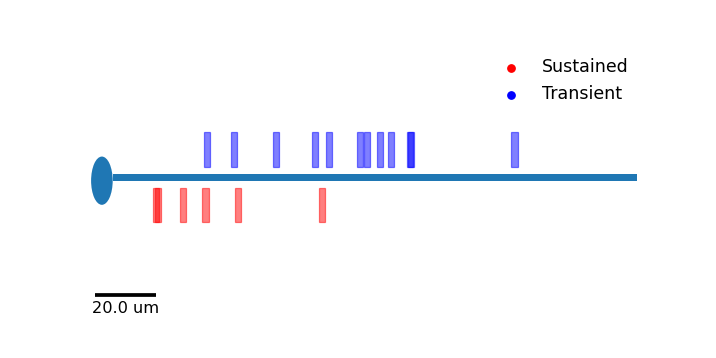

In [44]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ball_sticks(ax, model_params[exp_idx], y_off={"a": 0}, bp_width=2, incl_gaba=False)
ax.set_xlim(-100, 80)
ax.set_ylim(-20, 20)
# clean_axes(ax)
add_scalebar(
    ax,
    matchy=False,
    xfmt="%.1f um",
    sep=5,
    barwidth=3,
    fontsize=13,
    loc=3,
)
fig.savefig(os.path.join(base_path, "solo_sac_schematic.svg"), bbox_inches="tight")

In [ ]:
norm_fits["proximal"]["peak_df"](1000)